<img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" align="center" alt="" height="45" width="45"/>

# Using custom components with tf.py_function with Watson Machine Learning


Building models with standard components is straightforward, but to use any custom component with your models in Watson Machine Learning, you need to package your custom component code in a source distribution package and store that package in WML with your model.

Learn how to define a custom operation using the tf.py_function operation in TensorFlow. The custom operation is then used in a LeNet network for handwritten character recognition which is trained on the MNIST data set. The trained model is persisted, deployed and scored using the Watson Machine Learning Python Client.

Some familiarity with Python is helpful. This notebook is compatible with CP4D 3.0, Python 3.6, and tensorflow 1.15. Learn more about custom components in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener noreferrer">documentation</a>.

## Learning goals

This notebook focuses particularly on demonstrating how to use custom components in your model. You will learn how to:

-  define a custom operation and corresponding gradient using `tf.py_function`
-  create a LeNet model using the defined custom operation
-  train the model on the MNIST data set
-  create a package extension containing the custom tensor operation and associate it with a custom software specification
-  persist the library and the model with Watson Machine Learning
-  deploy the model in a deployment space
-  perform some classifications using the deployed model


## Contents

This notebook contains the following parts:

1.  [Create the operation for tf.py_function and download the library](#func)
2.	[Load data and initialize parameters](#load)
3.	[Create and train the LeNet model](#model)
4.  [Save the LeNet model locally](#save)
5.  [Setting up](#setup)
6.  [Save the custom library and model using Watson Machine Learning](#lib_persistence)
7.  [Deploy and perform prediction on the LeNet model (with deployment space only)](#Scoring)
8.  [Summary](#summary)


To get started on CP4D 3.0, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener no referrer">here</a>.

<a id="func"></a>
## 1. Configure the tf.py_function function

In this section, you will:
- [Create a custom operation for the tf.py_function](#createfunc)
- [Download the Python libraries](#downloadlib) that the tf.py_function needs

### 1.1 Create a custom operation for tf.py_function<a id="createfunc"></a>

When you create a custom operation for tf.py_function, you also need to create the corresponding gradient function. TensorFlow maps any function passed to the tf.py_function under the `PyFunc` operation type. TensorFlow models perform gradient calculation during training. Hence, a user defined `tf.py_function` operation requires a corresponding gradient function to be defined and mapped to the `PyFunc` operation type. In this example, `reshape_grad` is the gradient function for the `tf.py_function` operation.

In [1]:
!pip install --upgrade tensorflow==1.15

Requirement already up-to-date: tensorflow==1.15 in /opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages (1.15.0)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

def reshape_func(x):
    x = tf.cast(tf.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1]), tf.float32)
    x /= 255
    return x

def reshape_grad(op, grad):
    x = op.inputs[0]

    return grad

def create_py_func_with_grads(op, inp, tout, name=None, grad=None):
    grad_name = 'PyFuncGrad' + str(np.random.randint(0, 1e+8))

    tf.RegisterGradient(grad_name)(grad)
    g = tf.get_default_graph()

    with g.gradient_override_map({"PyFunc": grad_name}):
        return tf.py_function(op, inp, tout, name=name)

### 1.2 Download a sample custom package for a TensorFlow model<a id="downloadlib"></a>

A Python-distributable library needs to be created to store and deploy models that use operations defined through `tf.py_function`. The library must contain an `initialize_py_func()` function, which defines the `tf.py_function` operation. The operation defined within this function must have the same name as the operation created during model definition and training. Also, the `initialize_py_func()` function must be referenceable using the top-level module name. For example, if the top-level module in the python distribution package is `my_top_module`, then `initialize_py_func()` must be referenceable as `my_top_module.initialize_py_func()`.

Currently, only source-distributed libraries archived in `.zip` format are supported. Library distributions of type `wheels` and `eggs` are not supported.

Any 3rd party libraries that are required for the custom transformer must be defined as the dependency for the corresponding library that contains the transformer implementation. 

Download the sample library `custom_reshape_pyfunc.zip`, which defines the reshape operation.

In [4]:
!wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc.zip --output-document=custom_reshape_pyfunc.zip

--2020-05-12 03:30:51--  https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc.zip [following]
--2020-05-12 03:30:57--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3654 (3.6K) [application/zip]
Saving to: ‘custom_reshape_py

<a id="load"></a>
## 2. Load the data and initialize parameters

Download the <a href="http://yann.lecun.com/exdb/mnist/index.html" target="_blank" rel="noopener noreferrer">MNIST data set</a> from Yann LeCun's homepage using the built-in TensorFlow library.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Set the training and network parameters.

In [6]:
# Training Parameters
learning_rate = 0.001
training_iters = 10000
batch_size = 128
display_step = 10

# Network Parameters
n_classes = 10

Convert the labels to a binary matrix.

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

<a id="model"></a>
## 3. Create and train the LeNet model

In this section, you will create the LeNet model and then train it.

Define the placeholders and the default layer configurations for the network.

In [8]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28], name="x_input")
y = tf.placeholder(tf.float32, [None, n_classes])

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

The `create_py_func_with_grads` function defines a `tf.py_function` operation together with the corresponding gradient and returns the resulting tensor.

In [9]:
x_trans1 = create_py_func_with_grads(reshape_func, [x], tf.float32, name='ReshapeFunc', grad=reshape_grad)

Build the model.

In [10]:
# Convolution Layer -1
x_conv2d_l1 = tf.nn.conv2d(x_trans1, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l1 = tf.nn.bias_add(x_conv2d_l1, biases['bc1'])
x_relu_l1 = tf.nn.relu(x_w_bias_l1)
conv1_out = tf.nn.max_pool(x_relu_l1,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')


# Convolution Layer -2
x_conv2d_l2 = tf.nn.conv2d(conv1_out, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l2 = tf.nn.bias_add(x_conv2d_l2, biases['bc2'])
x_relu_l2 = tf.nn.relu(x_w_bias_l2)
conv2_out = tf.nn.max_pool(x_relu_l2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
fc1 = tf.reshape(conv2_out, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc1 = tf.nn.relu(fc1)

# Output, class prediction
conv_out = tf.add(tf.matmul(fc1, weights['out']), biases['out'], name="output_tensor")

predictor = tf.argmax(conv_out, 1, name="predictor")

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=conv_out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# To Evaluate model
correct_pred = tf.equal(tf.argmax(conv_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Train the model.

In [11]:
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1

# Create batches
total_batch = int(len(x_train) / batch_size)
batches_x = np.array_split(x_train, total_batch)
batches_y = np.array_split(y_train, total_batch)

# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = batches_x[step-1], batches_y[step-1]
    
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    print("Completed batch iteration: " + str(step*batch_size) )
    
    if step % display_step == 0:
        
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
               "{:.6f}".format(loss) + ", Training Accuracy= " + \
               "{:.5f}".format(acc) + "\n")
    step+=1
    
print("Model training finished!")

Completed batch iteration: 128
Completed batch iteration: 256
Completed batch iteration: 384
Completed batch iteration: 512
Completed batch iteration: 640
Completed batch iteration: 768
Completed batch iteration: 896
Completed batch iteration: 1024
Completed batch iteration: 1152
Completed batch iteration: 1280
Iter 1280, Minibatch Loss= 19930.208984, Training Accuracy= 0.25581

Completed batch iteration: 1408
Completed batch iteration: 1536
Completed batch iteration: 1664
Completed batch iteration: 1792
Completed batch iteration: 1920
Completed batch iteration: 2048
Completed batch iteration: 2176
Completed batch iteration: 2304
Completed batch iteration: 2432
Completed batch iteration: 2560
Iter 2560, Minibatch Loss= 10810.072266, Training Accuracy= 0.46512

Completed batch iteration: 2688
Completed batch iteration: 2816
Completed batch iteration: 2944
Completed batch iteration: 3072
Completed batch iteration: 3200
Completed batch iteration: 3328
Completed batch iteration: 3456
Compl

<a id="save"></a>
## 4. Save the LeNet model locally

In this section, you will use `SavedModelBuilderSave` to save the model locally.

Remove the previously created directory.

In [12]:
import os, shutil
save_path = './tf_model_mnist_test'
# delete dir if directory exists
if os.path.exists(save_path):
    shutil.rmtree(save_path)

Create `SignatureDef` metadata for the model.

In [13]:
from tensorflow.compat.v1.saved_model import build_tensor_info
classification_inputs = build_tensor_info(x)
classification_outputs_classes = build_tensor_info(predictor)

classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              tf.saved_model.signature_constants.CLASSIFY_INPUTS:
                  classification_inputs
          },
          outputs={
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES:
                  classification_outputs_classes
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

print("classification_signature content:")
print(classification_signature)

W0512 03:31:31.405272 140348130891584 deprecation.py:323] From <ipython-input-13-03b2836f00f9>:2: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


classification_signature content:
inputs {
  key: "inputs"
  value {
    name: "x_input:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 28
      }
      dim {
        size: 28
      }
    }
  }
}
outputs {
  key: "classes"
  value {
    name: "predictor:0"
    dtype: DT_INT64
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
method_name: "tensorflow/serving/classify"



Use TensorFlow's `SavedModelBuilder` API to save the LeNet model locally.

In [14]:
# Build the signature_def_map.

builder = tf.saved_model.builder.SavedModelBuilder(save_path)
main_op = tf.group(tf.tables_initializer(), name='main_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          'predict_images': classification_signature,
      },
      main_op=main_op)

builder.save()

b'./tf_model_mnist_test/saved_model.pb'

<a id="setup"></a>
## 5. Set up the environment

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your CP4D cluster, you do not need to install this package as it comes pre-installed with the notebooks. The installation code below is for demonstration but is non-executable at this stage.
</div>

In [15]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Authenticate the Python client on CP4D 3.0.**<br><br>

<div class="alert alert-block alert-info">To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_current/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation.</a></div>

**Action**: Enter your credentials in the following cell.

In [16]:
# Enter your credentials here
import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": "url",
"version": "3.0.0"
}

In [17]:
client = WatsonMachineLearningAPIClient(wml_credentials)

<div class="alert alert-block alert-info">
You have a choice to either save the model in the <b>project</b> or the <b>deployment space</b>:<br><br>
    <li> If you're saving the model in your project, you have to set the default project using the python client.</li><br>
    <li>If you're saving the model in the deployment space, you have to obtain the space UID of the deployment space you've created. Then you'd use this to set the default space using the python client. From there you'll be able to deploy and score the model in your deployment space.</li></div>

### To set the default project, use the following code.

In [18]:
from project_lib import Project
project = Project.access()
project_id = project.get_metadata()["metadata"]["guid"]

client.set.default_project(project_id)

'SUCCESS'

### To set the default space, follow these steps.

<div class="alert alert-block alert-info">
You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Analytics deployments</b> under <b>Analyze</b> from the Navigation Menu on the top left of this page.</div>

Alternatively, you can create a deployment and obtain its UID using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [19]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [21]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 594b22d1-588c-4de0-9cbd-d98e6fa890e8


You can set the default space using the cell below.

In [22]:
client.set.default_space(space_uid)

Unsetting the project_id ...


'SUCCESS'

<a id="lib_persistence"></a>
## 6. Save the custom library and model using Watson Machine Learning


In this section, you'll use the Python client to:
- Save the library `custom_reshape_pyfunc.zip`, a <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener no referrer">custom component</a>, as a package extension.
- Create a custom software specification and add the package extension containing the custom library. This will be used to configure the online deployment environment for the model.

### 6.1 Save the library as a package extension

In [23]:
# Custom library
cust_lib_zip_path = "custom_reshape_pyfunc.zip"

Create the metadata for the new package extension.

In [24]:
# Package extension metadata
meta_prop_pkg_ext = {
     client.package_extensions.ConfigurationMetaNames.NAME: "My custom library",
     client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Package extension for library",
     client.package_extensions.ConfigurationMetaNames.TYPE: "pip_zip"
}

Store the package extension associated with the custom library.

In [25]:
# Store the package extension
package_ext_details = client.package_extensions.store(meta_props=meta_prop_pkg_ext,file_path=cust_lib_zip_path)

Creating package extensions
SUCCESS


In [26]:
package_ext_details

{'metadata': {'space_id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8',
  'name': 'My custom library',
  'asset_id': '7bf16401-43ca-483d-b21c-ad7f78386529',
  'asset_type': 'package_extension',
  'created_at': '2020-05-12T03:33:21Z'},
 'entity': {'package_extension': {'type': 'pip_zip',
   'href': '/v2/asset_files/package_extension/My_custom_library_JVQGuZL-XE.zip?space_id=594b22d1-588c-4de0-9cbd-d98e6fa890e8&signature=2lucdHFm42Jq%2Fa%2FCTnUnyw%3D%3D%3AcwWOVNHv5uvA%2FTTNgGPm1chJ%2FRLOBCh5iQoHwyzsY7GGXfTGXGi6znM16J2zDgOLMcL5LXe16DeEGP4YClm9Ts6dbWYoPQhiYwGiq203CRTl%2B44r58TdI2Eqjcs%2FQntQZ6iV3TwE2gh9Nlb7hDlvben8mWTPd%2BiHfIfvmj%2FEEEeSfSXX96%2F8UMHJ%2FRE4uGRTQGmU6L1oivryIS0SeLcOU9jc1VYJL7l%2BAhS8yik%3D'}}}

You can list the available package extensions with the following code.

In [27]:
# List all package extensions
client.package_extensions.list()

-----------------  ------------------------------------  -------  --------------------
NAME               ASSET_ID                              TYPE     CREATED_AT
My custom library  7bf16401-43ca-483d-b21c-ad7f78386529  pip_zip  2020-05-12T03:33:21Z
-----------------  ------------------------------------  -------  --------------------


<div class="alert alert-block alert-info">
From the list of package extensions, you can see that the custom library is successfully saved.</div>

Get the UID of the package extension.

In [28]:
# Obtain package extension UID
package_ext_uid = client.package_extensions.get_uid(package_ext_details)
print('Package extension UID = {}'.format(package_ext_uid))

Package extension UID = 7bf16401-43ca-483d-b21c-ad7f78386529


### 6.2 Create the associated software specification

Create the metadata for your custom software specification to associate the previous package extension to.

In [29]:
# Software specification metadata.
base_software_spec_uid = client.software_specifications.get_uid_by_name('tensorflow_1.15-py3.6')

meta_prop_sw_spec = {
     client.software_specifications.ConfigurationMetaNames.NAME: "Custom pyfunction with tensorflow_1.15-py3.6",
     client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Software specification for derived lib",
     client.software_specifications.ConfigurationMetaNames.PACKAGE_EXTENSIONS : [{
         "guid": package_ext_uid
     }],
     client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {
         "guid": base_software_spec_uid
     }
}

Store the custom software specification.

In [30]:
# Store software specification
software_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)

In [31]:
software_spec_details

{'metadata': {'created_at': '2020-05-12T03:33:24Z',
  'name': 'Custom pyfunction with tensorflow_1.15-py3.6',
  'description': 'Software specification for derived lib',
  'asset_id': '43a9eee7-e05c-4a5d-bfb9-33a55df076ce',
  'asset_type': 'software_specification',
  'space_id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8',
  'href': '/v2/software_specifications/43a9eee7-e05c-4a5d-bfb9-33a55df076ce'},
 'entity': {'software_specification': {'type': 'derived',
   'display_name': 'Custom pyfunction with tensorflow_1.15-py3.6',
   'base_software_specification': {'guid': '2b73a275-7cbf-420b-a912-eae7f436e0bc',
    'href': '/v2/software_specifications/2b73a275-7cbf-420b-a912-eae7f436e0bc'},
   'package_extensions': [],
   'software_configuration': {'included_packages': [{'name': 'tensorflow',
      'version': '1.15'},
     {'name': 'keras', 'version': '2.2.5'}],
    'platform': {'name': 'python', 'version': '3.6'}}}}}

<div class="alert alert-block alert-info">
    To list the software specifications, run <tt>client.software_specifications.list()</tt>. You'll see that the custom software specification has been successfully created.<br><br>
    To find more information about creating a custom software specification, or to learn about the available frameworks, <b>Software Specifications</b>, and their respective <b>Types</b>, visit the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html" target="_blank" rel="noopener no referrer">documentation</a>.</div>

In [32]:
client.software_specifications.list()

--------------------------------------------  ------------------------------------  -------
NAME                                          ASSET_ID                              TYPE
default_py3.6                                 0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
scikit-learn_0.20-py3.6                       09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
ai-function_0.1-py3.6                         0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                                    0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6                             10ac12d6-6b30-4ccd-8392-3e922c096a92  base
scikit-learn_0.22-py3.6                       154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                                  1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
tensorflow_1.15-py3.6                         2b73a275-7cbf-420b-a912-eae7f436e0bc  base
pytorch_1.2-py3.6                             2c8ef57d-2687-4b7d-acce-01f94976dac1  base
spark-mllib_2.3   

Get the UID of the new software specification.

In [33]:
# Obtain software specification UID
software_spec_uid = client.software_specifications.get_uid(software_spec_details)
print('New Software Specification UID = {}'.format(software_spec_uid))

New Software Specification UID = 43a9eee7-e05c-4a5d-bfb9-33a55df076ce


Add the package extension containing your custom library to the newly created software specification. 

In [34]:
# Associate package extension.
client.software_specifications.add_package_extension(software_spec_uid, package_ext_uid)

'SUCCESS'

You can see the details of the custom software specification by running the following code.

In [35]:
client.software_specifications.get_details(software_spec_uid)

{'metadata': {'name': 'Custom pyfunction with tensorflow_1.15-py3.6',
  'asset_id': '43a9eee7-e05c-4a5d-bfb9-33a55df076ce',
  'href': '/v2/software_specifications/43a9eee7-e05c-4a5d-bfb9-33a55df076ce',
  'asset_type': 'software_specification',
  'created_at': '2020-05-12T03:33:24Z'},
 'entity': {'software_specification': {'type': 'derived',
   'display_name': 'Custom pyfunction with tensorflow_1.15-py3.6',
   'base_software_specification': {'guid': '2b73a275-7cbf-420b-a912-eae7f436e0bc',
    'href': '/v2/software_specifications/2b73a275-7cbf-420b-a912-eae7f436e0bc'},
   'package_extensions': [{'metadata': {'rov': {'mode': 0,
       'collaborator_ids': {}},
      'space_id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8',
      'usage': {'last_updated_at': '2020-05-12T03:33:23Z',
       'last_updater_id': '1000330999',
       'last_update_time': 1589254403357,
       'last_accessed_at': '2020-05-12T03:33:23Z',
       'last_access_time': 1589254403357,
       'last_accessor_id': '1000330999',
  

### 6.3 Create a model archive

The model that needs to be saved with the Python client needs to be of tar.gz format.

First, remove any existing model archive with the same name, then create a new one.

In [36]:
import os
if os.path.exists('tf_mnist_pyfunc.tar.gz'):
    os.remove('tf_mnist_pyfunc.tar.gz')

In [37]:
cd tf_model_mnist_test

/home/wsuser/work/tf_model_mnist_test


In [38]:
ls

saved_model.pb  variables/


In [39]:
!tar -cvf ../tf_mnist_pyfunc.tar *

saved_model.pb
variables/
variables/variables.data-00000-of-00001
variables/variables.index


In [40]:
cd ../

/home/wsuser/work


In [41]:
!gzip tf_mnist_pyfunc.tar

In [42]:
model_path = 'tf_mnist_pyfunc.tar.gz'

### 6.4 Save the model
Now, you can create the model metadata with the custom software specification you just created.

In [43]:
meta_props={
     client.repository.ModelMetaNames.NAME: "Tensorflow custom library",
     client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
     client.repository.ModelMetaNames.TYPE: "tensorflow_1.15"
}

You can extract the model UID from the saved model details.

In [44]:
# Save the model
model_artifact = client.repository.store_model(model=model_path, meta_props=meta_props)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 81a55ede-932a-44d5-86be-ef48cbed778d


Get the saved model metadata using the model UID.

In [45]:
# Details about the model.
from pprint import pprint
pprint(model_artifact)

{'entity': {'content_status': {'state': 'persisted'},
            'name': 'Tensorflow custom library',
            'software_spec': {'id': '43a9eee7-e05c-4a5d-bfb9-33a55df076ce'},
            'space': {'href': '/v4/spaces/594b22d1-588c-4de0-9cbd-d98e6fa890e8',
                      'id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8'},
            'type': 'tensorflow_1.15'},
 'metadata': {'created_at': '2020-05-12T03:33:45.002Z',
              'guid': '81a55ede-932a-44d5-86be-ef48cbed778d',
              'href': '/v4/models/81a55ede-932a-44d5-86be-ef48cbed778d?space_id=594b22d1-588c-4de0-9cbd-d98e6fa890e8',
              'id': '81a55ede-932a-44d5-86be-ef48cbed778d',
              'modified_at': '2020-05-12T03:33:49.002Z',
              'name': 'Tensorflow custom library',
              'owner': '1000330999',
              'space_id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8'}}


In [46]:
client.repository.list_models()

------------------------------------  -------------------------  ------------------------  ---------------
GUID                                  NAME                       CREATED                   TYPE
81a55ede-932a-44d5-86be-ef48cbed778d  Tensorflow custom library  2020-05-12T03:33:45.002Z  tensorflow_1.15
------------------------------------  -------------------------  ------------------------  ---------------


<div class="alert alert-block alert-info">
From the list of models, you can see that your model is successfully saved.<br><br>
If you've set the default project, this means you've saved the model in your project. You can see the saved model in your project UI by clicking on your project name in the breadcrumb at the top of the application.<br><br>
If you've set the default space, this means that you've saved the model in your deployment space. You can view your model by selecting <b>Analytics Deployments</b> under <b>Analyze</b> from the Navigation Menu and clicking on your deployment space name.</div>

If you're using a deployment space, proceed to Section 7: [Deploy and perform prediction on the LeNet model (with deployment space only)](#Scoring). If not, you may skip to the [summary](#summary).

<a id='Scoring'></a>
## 7. Deploy and perform prediction on the LeNet model (with deployment space only)

In this section, you will:
- Deploy the saved model that uses the custom transformer
- Perform predictions

You will use the WML Python client to perform these tasks.

### 7.1 Deploy the model

In [47]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Tensorflow custom library deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [48]:
# Create an online deployment.
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '81a55ede-932a-44d5-86be-ef48cbed778d' started

#######################################################################################


initializing.............................................................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ec0c61f1-9134-48f4-a4e5-0feaa0efc60e'
------------------------------------------------------------------------------------------------




In [49]:
# List the deployments.
client.deployments.list()

------------------------------------  ------------------------------------  -----  ------------------------  -------------
GUID                                  NAME                                  STATE  CREATED                   ARTIFACT_TYPE
ec0c61f1-9134-48f4-a4e5-0feaa0efc60e  Tensorflow custom library deployment  ready  2020-05-12T03:33:51.111Z  model
------------------------------------  ------------------------------------  -----  ------------------------  -------------


<div class="alert alert-block alert-info">
From the list of deployed models, you can see that the custom model was successfully deployed in the deployment space.</div>

Now, you can check the details of your deployment.

In [50]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment UID = {}'.format(deployment_uid))

Deployment UID = ec0c61f1-9134-48f4-a4e5-0feaa0efc60e


In [51]:
# Deployment details.
pprint(client.deployments.get_details(deployment_uid))

{'entity': {'asset': {'href': '/v4/models/81a55ede-932a-44d5-86be-ef48cbed778d?space_id=594b22d1-588c-4de0-9cbd-d98e6fa890e8',
                      'id': '81a55ede-932a-44d5-86be-ef48cbed778d'},
            'custom': {},
            'description': '',
            'name': 'Tensorflow custom library deployment',
            'online': {},
            'space': {'href': '/v4/spaces/594b22d1-588c-4de0-9cbd-d98e6fa890e8',
                      'id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8'},
            'space_id': '594b22d1-588c-4de0-9cbd-d98e6fa890e8',
            'status': {'online_url': {'url': 'https://zen-cpd-zen.apps.ocp43-ceph-defect-01.os.fyre.ibm.com/v4/deployments/ec0c61f1-9134-48f4-a4e5-0feaa0efc60e/predictions'},
                       'state': 'ready'}},
 'metadata': {'created_at': '2020-05-12T03:33:51.111Z',
              'description': '',
              'guid': 'ec0c61f1-9134-48f4-a4e5-0feaa0efc60e',
              'href': '/v4/deployments/ec0c61f1-9134-48f4-a4e5-0feaa0efc60e',


### 7.2 Score the deployed model

Prepare sample scoring data.

In [52]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
# Prepare scoring payload.
image = x_test[0:10].tolist()
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': image
    }]
}

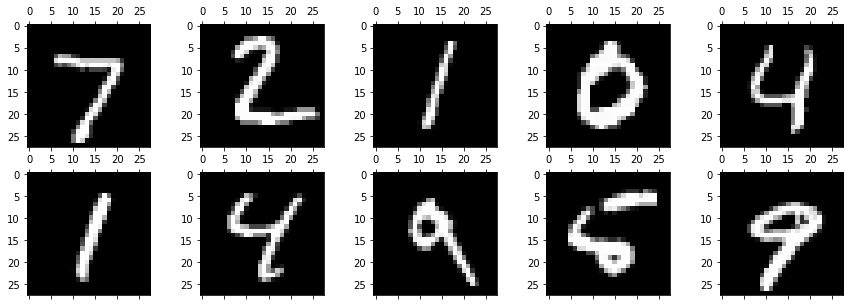

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize some digits from the data set.
import matplotlib.pyplot as plt
%matplotlib inline
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15,5))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i in range (len(ax)):
    plt.gray()
    ax[i].matshow(x_test[i])
plt.show()

In [55]:
# Score data and predict the handwritten digits. 
predictions = client.deployments.score(deployment_uid, job_payload)
print(predictions)

{'predictions': [{'values': [7, 2, 1, 0, 4, 1, 4, 8, 0, 9]}]}


### 7.3 Delete artifacts

Use the following methods to delete the deployment, model, custom software specification, and package extension if they are no longer needed.

In [56]:
# client.deployments.delete(deployment_uid)

In [57]:
# client.repository.delete(model_uid)

In [58]:
# client.software_specifications.delete(software_spec_uid)

In [59]:
# client.package_extensions.delete(package_ext_uid)

<a id="summary"></a>
## 8. Summary

In this notebook we learnt how to create a custom Python operation using TensorFlow's `tf.py_function` and used it on the LeNet model for MNIST.

We also learned how to use the `watson-machine-learning-client` to store a library as a package extension to use the same operation with WML.

Finally, we stored our custom LeNet model using a software specification associated with the package extension, so this model could be deployed and scored later using WML.

### Resources 

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:
<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener noreferrer">CP4D 3.0</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener noreferrer">Custom components</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html#creating-a-custom-software-specification-in-a-project" target="_blank" rel="noopener no referrer">Custom software specifications</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://www.tensorflow.org/api_docs/python/tf/py_function" target="_blank" rel="noopener noreferrer">tf.py_function</a></li>
 </div>

### References
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

Creative Commons Zero v1.0 Universal License: The code in section [2.1 Create a custom operation for tf.py_function](#createfunc) is based on the following:
- <a href="https://github.com/tensorflow/tensorflow/issues/1095" target="_blank" rel="noopener noreferrer">https://github.com/tensorflow/tensorflow/issues/1095</a>
- <a href="https://gist.github.com/harpone/3453185b41d8d985356cbe5e57d67342" target="_blank" rel="noopener noreferrer">https://gist.github.com/harpone/3453185b41d8d985356cbe5e57d67342</a>

### Author
**Srikrishna S Bhat**, M. Tech, is a Software Engineer at IBM Watson Machine Learning Team

<hr>
Copyright © 2018-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>